# Machine learning on autism data

Pr Fadi Fayez Thabtah, from the Digital Technology Departement of Manukau Institute of Technology of Auckland has created an app, the Autism Spectrum Disorder Tests App, aiming at understanding the main characteristics of autistic patients in order to better detect ASD. By answering a series of 10 questions, and giving a few information about themselves, users of the app have contributed in creating datasets related to autism. It has been divided in three parts : children (from 4 to 11 years old), adolescents (12 to 18 years old), and adults. 

These datasets are the starting for this project of machine learning, aiming at creating an algorithm that detect autism from the responses to those 10 questions.

<img src="photos/asd.png" alt="asd" width="150"/>




## 1. Importing the required modules

In [1]:
from scipy.io import arff
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

## 2. Loading the data

The data is arff files, which contain two parts : one with metadata, and one with data. The first 10 columns are  responses to 10 different questions about their life habits. The results of the questions is summarized in the result variable, a score relative to the number of yes answers. 

<img src="photos/app.png" alt="app" width="600"/>

We also have data about the person : gender, ethnicity, jundice when he was young, country, age, whether one parent have a ASD-like trouble ('austim')... We also know if the child is autistic or not ('Class/ASD'). We also have a few information about the person responding the questionnaire (its relation to the child, its use of the app before etc.). 

We have three different data sets (child, adolescent, adult) that I want to merge into a single one in order to have more observations and therefore better predictions. 

In [25]:
# I load the data from the arff file into two files (data and meta) for each data set 
data_child, meta_child = arff.loadarff('Autism-Child-Data.arff')
data_child = pd.DataFrame(data_child)

data_ado, meta_ado = arff.loadarff('Autism-Adolescent-Data.arff')
data_ado = pd.DataFrame(data_ado)

data_adult, meta_adult = arff.loadarff('Autism-Adult-Data.arff')
data_adult = pd.DataFrame(data_adult)
data_adult = data_adult.drop(52) # That guy was 383 years old..

# I store the names of columns in different lists to check whether we have the same variables
names_child = list(data_child.columns.values)
names_ado = list(data_ado.columns.values)
names_adult = list(data_adult.columns.values)

# I assert that the variables are the same
assert names_child==names_ado
assert names_child==names_adult

## 3. Handling missing values

I want to handle missing values by replacing it by their mean. I want to to this before merging the different data sets because I hypothesis that some variables are very different from a child to an adult. Therefore, I search for missing values and handle it before merging the datasets. 

In [26]:
# I want to know where my missing values are.
for name in names_child:
    if data_child[name].isnull().sum()!=0:
        print("There are missing values in the child dataset in the " + name + " column")
    if data_ado[name].isnull().sum()!=0:
        print("There are missing values in the adolescent dataset in the " + name + " column")
    if data_adult[name].isnull().sum()!=0:
        print("There are missing values in the adult dataset in the " + name + " column")

There are missing values in the child dataset in the age column
There are missing values in the adult dataset in the age column


We observe that missing values are only present on age variable in child and adult datasets. I can replace them by the mean of their category (mean age of children, mean age of adults).

In [27]:
# Fill nas with the mean of the column
age_mean_child = data_child.age.mean()
data_child['age'] = data_child['age'].fillna(age_mean_child)

age_mean_ado = data_ado.age.mean()
data_ado['age'] = data_ado['age'].fillna(age_mean_ado)

age_mean_adult = data_adult.age.mean()
data_adult['age'] = data_adult['age'].fillna(age_mean_adult)

for name in names_child:
    assert data_child[name].isnull().sum()==0
    assert data_ado[name].isnull().sum()==0
    assert data_adult[name].isnull().sum()==0

## 4. Merging datasets

I merge the three datasets. We should have always the same number of variables (21) and a number of observations which equals the sum of all observations (292+104+704 = 1100).

In [28]:
data = pd.concat([data_child, data_ado, data_adult])
print(data_child.shape)
print(data_ado.shape)
print(data_adult.shape)
print(data.shape)

names = list(data.columns.values)

(292, 21)
(104, 21)
(703, 21)
(1099, 21)


## 5. Tidying data

We start by turning values into numerical values.

In [29]:
#Turn the numeric strings in real numerical data
numeric = names[0:11]
for name in numeric:
    data[name] = pd.to_numeric(data[name])

data['result'] = pd.to_numeric(data['result'])
data['age'] = pd.to_numeric(data['age'])

We turn our binary variables into numerical ones. I chose to recode as it follows:
- for gender, 0 is man and 1 is woman
- for autism, jundice, and used_app_before,  0 is no and 1 is yes

In [30]:
#We turn our binary variables into numerical ones 
data.loc[data['gender'] == b'm', 'gender'] = 0
data.loc[data['gender'] == b'f', 'gender'] = 1

binary=['austim', 'jundice', 'used_app_before']
for name in binary:
    data.loc[data[name] == b'no', name] = 0
    data.loc[data[name] == b'yes', name] = 1

data.loc[data['Class/ASD'] == b'NO', 'Class/ASD'] = 0
data.loc[data['Class/ASD'] == b'YES', 'Class/ASD'] = 1
    
data.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,...,0,b'Others',0,0,b'Jordan',0,5.0,b'4-11 years',b'Parent',0
1,1,1,0,0,1,1,0,1,0,0,...,0,b'Middle Eastern ',0,0,b'Jordan',0,5.0,b'4-11 years',b'Parent',0
2,1,1,0,0,0,1,1,1,0,0,...,0,b'?',0,0,b'Jordan',1,5.0,b'4-11 years',b'?',0
3,0,1,0,0,1,1,0,0,0,1,...,1,b'?',1,0,b'Jordan',0,4.0,b'4-11 years',b'?',0
4,1,1,1,1,1,1,1,1,1,1,...,0,b'Others',1,0,b'United States',0,10.0,b'4-11 years',b'Parent',1


Age_desc is a variable that is useful to define the three types of public (children, adolescent, and adult). But, as I have merged the data set, handled the missing values on the age column and kept the age column, it is not useful anymore. We can drop it.

In [31]:
data = data.drop('age_desc', axis=1)

To simplify the  analysis, I drop the country of residence, the ethnicity and the relation to the person who is answering. I here assume that they have not as much influence than the other data. 

In [32]:
analyse = data.drop('ethnicity', axis=1)
analyse = analyse.drop('contry_of_res', axis=1)
analyse = analyse.drop('relation', axis=1)

In order for our data set to be ready, I create different arrays: one with target variable (autistic or not, with the variable Class/ASD), and one with all the other variables.

In [46]:
# Create arrays for the features and the response variable
y = analyse['Class/ASD'].values
X = analyse.drop('Class/ASD', axis=1).values

We therefore have those variables in X:

| Variable       | Values          | What it corresponds to  |
| :------------- |:-------------:| :-----:|
| A1_Score      | 0 or 1 | Response to question 1 |
| A2_Score      | 0 or 1 | Response to question 2 |
| A3_Score      | 0 or 1 | Response to question 3 |
| A4_Score      | 0 or 1 | Response to question 4 |
| A5_Score      | 0 or 1 | Response to question 5 |
| A6_Score      | 0 or 1 | Response to question 6 |
| A7_Score      | 0 or 1 | Response to question 7 |
| A8_Score      | 0 or 1 | Response to question 8 |
| A9_Score      | 0 or 1 | Response to question 9 |
| A10_Score      | 0 or 1 | Response to question 10 |
| age      | from 4 to 64 | Age of the person |
| gender     | 0 or 1      |   Gender of the person |
| jundice | 0 or 1      |    Corresponds to 1 if the person has had jundice when he/she was a child |
| austim     | 0 or 1 | Corresponds to 1 if someone in the family has had troubles related to autism |
| used_app_before      | 0 or 1 | Corresponds to 1 if the app has already been used for that person |
| result      | from 0 to 10 | Corresponds to the sum of scores of questions 1 to 10 |

We can look upon summary statistics about the variables with the code below:

In [34]:
# Summary statistics upon X variables 
analyse.drop('Class/ASD', axis=1).describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result
count,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000
mean,0.698817,0.483167,0.552320,0.530482,0.587807,0.444040,0.477707,0.606005,0.413103,0.622384,21.700459,0.431301,0.150136,0.140127,0.024568,5.415833
std,0.458981,0.499944,0.497481,0.499297,0.492454,0.497085,0.499730,0.488856,0.492615,0.485012,12.877419,0.495483,0.357368,0.347277,0.154874,2.521125
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,21.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,1.000000,0.000000,0.000000,0.000000,7.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,64.000000,1.000000,1.000000,1.000000,1.000000,10.000000


## 6. Visualizing the data

### 6.1. Bar plot

I started by plotting the variable result (which equals to the sum of responses to the 10 questions) in function of ASD (autism=0 if the child is not on the spectrum, autism=1 if he is).

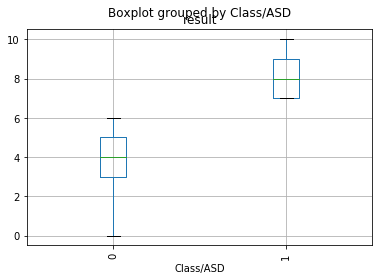

In [35]:
data.boxplot(column='result', by="Class/ASD", rot=90)
plt.show()

### 6.2. Principal Component Analysis

The problem in that visualization is that it allows us only to plot one variable in function of the target variable (autism). I therefore choose to realize a PCA, or Principal Component Analysis, which analyses the principal components in a dataset, in order to reduce dimensionality. 

In [36]:
# Creating the scaler
scaler = StandardScaler()

# We fit and transform our data relatively to that scaler
X_scale = scaler.fit_transform(X)

#We initiate the PCA object with 3 components
pca = PCA(n_components=3)

# We fit and transform our data with that scaler
principal_components = pca.fit_transform(X_scale)

# We create a data set with the principal components and the target variable
final = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2', 'PC3'])
final = final.assign(y=analyse[['Class/ASD']].values)

We want to look at whether one component outweight the other. In fact, if one was very important, we would not need to build a big algorithm but only predict the target directly from one variable.

In [37]:
# We print pca's components 
print(pca.components_)

[[-0.14112311 -0.16952401 -0.30292909 -0.30357202 -0.32455384 -0.35863651
  -0.20935014 -0.12368453 -0.34942077 -0.26878048  0.12660733  0.0073815
  -0.08942475 -0.08150507 -0.0224726  -0.49877509]
 [-0.42849236  0.0764243   0.1321379  -0.17554095  0.031006    0.18798552
   0.04289597 -0.31093054 -0.03232996 -0.06870144 -0.53282467 -0.34261602
   0.31895288 -0.15643589  0.29026807 -0.09974525]
 [-0.11941516  0.40927762  0.15197953  0.16222589 -0.1139706   0.04291616
  -0.39579334 -0.35692603  0.04097964 -0.09674782  0.17350774  0.39369106
   0.31343056  0.41470919  0.03200707 -0.0505297 ]]


We see that there is no variable that is significantly high relative to the other. It is therefore meaningful to predict autism on the basis of all variables or at least more than one of them. 

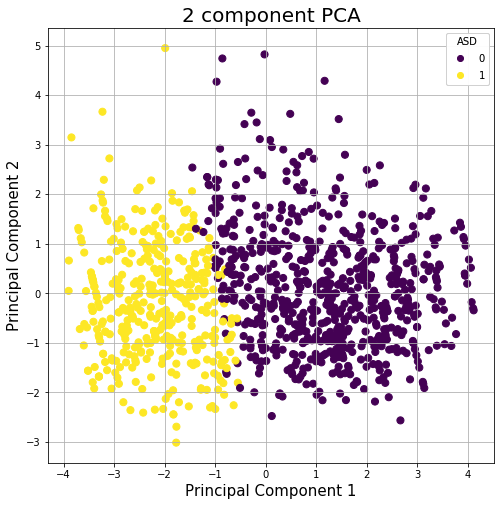

In [38]:
# Plotting the data in function of the principal components 

# I create the space upon which I will plot the data
fig = plt.figure(figsize = (8,8)) 
ax = fig.add_subplot(1,1,1) 
ax.grid()

# I set the labels and title of the plot
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

# I make a scatter plot with the first two components as X and Y and the target variable (final['y']) as the color of the points
scatter = plt.scatter(principal_components[:,0], principal_components[:,1], c = final['y'], s=50, label = final['y']) # We select the first two components to be plotted

# I create the legend for the color 
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="ASD")
ax.add_artist(legend1)

# I show the plot
plt.show()

Here, I see that I can explain a lot with only two components. **But how much does the other components explain ?** 
In order to answer this question, I can do two things :
* **plot how much the component explains variance** : the PCA calculate the weight of every component in the explained variance of the model. It is stored in the explained_variance_ attribute of the PCA (available at pca.explained_variance_). I see that the first component has a huge weight in the explained variance. *But this method does not show us the percentage of total variance.*

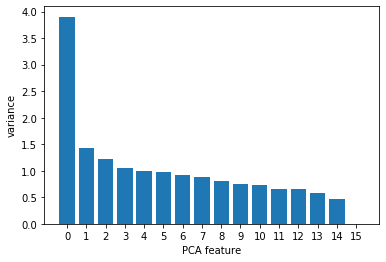

In [42]:
# Plot the explained variances
pca = PCA()
pca.fit_transform(X_scale)
features = range(pca.n_components_) # I store the weight of the components in "features" variable
plt.bar(features, pca.explained_variance_) # I plot the different components as a bar plot

# I set the labels
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)

# I show the plot 
plt.show()

* **plot the ratio of variance explained by the components** : it is stored in the PCA's explained_variance_ratio_ attribute. I can print it or plot it, as I have done below. If I want to explain autism with a reduced amount of components, I can choose to explain 80% of variance for example, and therefore use only the 10 first components (when the ratio is higher than 0.8). 

[0.24366262 0.33229455 0.40858556 0.47390709 0.53576303 0.59727539
 0.65467179 0.70998047 0.76023197 0.80710896 0.85285476 0.89428021
 0.93489365 0.97111163 1.         1.        ]


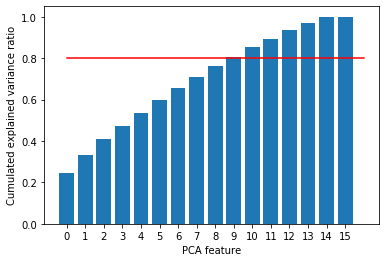

In [43]:
# Print the explained_variance_ratio cumulated to see how many components it is required to explain a certain amount of variance
print(pca.explained_variance_ratio_.cumsum())


# Plot the explained variance ratios
plt.bar(features, pca.explained_variance_ratio_.cumsum()) # I plot the different components as a bar plot

# I create a line at 80% of cumulated variance
x = range(17)
y=np.zeros((17,))
for i in range(17):
    y[i]=0.8
plt.plot(x, y, '-r', label='y=2x+1')

# I set the labels
plt.xlabel('PCA feature')
plt.ylabel('Cumulated explained variance ratio')
plt.xticks(features)

# I show the plot 
plt.show()

## 7. Testing models

### 7.1. K-Nearest Neighbors



In [47]:
# Create a k-NN classifier with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=6)
X_train, X_test, y_train, y_test = train_test_split(X, list(y), test_size = 0.3, random_state=42, stratify=y)
# Fit the classifier to the data
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(knn.score(X_test, y_test))

X2_train, X2_test, y2_train, y2_test = train_test_split(principal_components[:,0:2], y, test_size = 0.3, random_state=42, stratify=y)

knn2 = KNeighborsClassifier(n_neighbors=3)
# Fit the classifier to the data
knn2.fit(X2_train, y_train)
y_pred = knn2.predict(X2_test)
print(knn2.score(X2_test, y_test))

0.9818181818181818
0.9787878787878788


[[98.122  2.564]
 [ 1.878 97.436]]


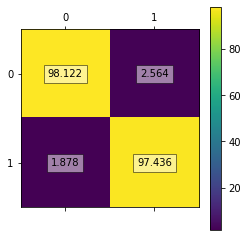

In [48]:
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = np.round(conf_matrix/np.sum(conf_matrix, axis=0)*100, 3)
plt.matshow(conf_matrix)
for (j,i), label in np.ndenumerate(conf_matrix):
    plt.text(i,j,label,ha='center',va='center', bbox=dict(facecolor='white', alpha=0.5))
plt.colorbar()
print(conf_matrix)

### 7.2. Logistic Regression

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
No handles with labels found to put in legend.


0.990909090909091
0.9787878787878788
[[-4.39147204 -1.14069033]]


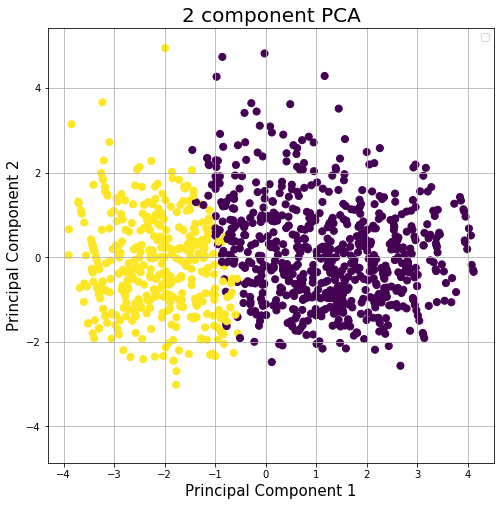

In [49]:
from sklearn.linear_model import LinearRegression, RidgeClassifier, LogisticRegression
reg = LogisticRegression()
reg.fit(X_train, y_train)
y_pred=reg.predict(X_test)
print(reg.score(X_test, y_test))



reg2 = LogisticRegression()
reg2.fit(X2_train, y_train)
y2_pred=reg2.predict(X2_test)
print(reg2.score(X2_test, y_test))
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
plt.scatter(principal_components[:,0], principal_components[:,1], c = final['y'], s=50)
ax.legend()
ax.grid()

t  = reg2.coef_
print(t)
plt.plot(t)
plt.show()


## 8. Implementation of K-Nearest Neighbors


The idea is to classify data on the basis of their euclidian distance to the other points. The euclidian distance is a distance that calculate the square root of the sum of the squared difference between the coordinates of two points:

$$ \begin{equation}  D_{e}(x,y) = \sqrt{\sum_{j=1}^n (x_{j} - y_{j})^{2}} \end{equation} $$

The basis of the model is that we are going to look at a certain number _k_ of points close to the point we want to predict the value. Then, we will predict his value based on the mean of the _k_ points close to it.

In [57]:
# Defining the Euclidian distance function 
def EuclidianDistance(row1, row2):
    return np.sqrt(np.dot(np.array(row1)-np.array(row2),np.array(row1)-np.array(row2)))

### 8.1. Fit step

Every machine learning algorithm starts with a step in which we fit the model to the data. In a K-Nearest Neighbors algorithm, there is no real model to fit because each prediction is made on the basis of the training observations. In the fit step, we only store the training data in the X_train and y_train variables. 
We also set the number of neighbors.

In [76]:
# W we store the training data and define the number of neighbor
X2_train = X2_train
y_train = y_train
k = 3 # Number of neighbours

### 8.2. Predict step

This is in this step that we predict the values from the training set we have loaded. 
First, we create a "distance" matrix. This is at the beginnning an empty matrix. With a for loop, we calculate the distance between observation _i_ of the test set with the observation _j_ of the train set. 

In [77]:
# For every observation in X_test, we calculate the distance to all X_train observations. 
N = X_test.shape[0] # number of observation in X_test
M = X_train.shape[0] # number of observation in X_train
distance=np.zeros((N, M)) # We create an empty matrix to be filled by the distances
for i in range(N):
    for j in range(M):
        distance[i, j] = EuclidianDistance(X2_test[i,:], X2_train[j,:]) # we calculate the Euclidian distance for the observation i of the X_test, and the observation j of the X_train

Then, for every observation in X_test, we compute the mean of the _k_ neighbors. We sort the indexes from the closest to the farest, and then we compute the mean based on the k first indexes. We then round the mean because we want a value that equals 0 or 1 (autistic or not). It is important that we round the mean to the higher value: we prefer to diagnosis someone that is not autist as autist rather than making a mistake by telling someone he's not autist when he is. Therefore, when the mean is 0.5, we prefer to tell that the person is autist (therefore we round the mean to 1). 

In [78]:
# For every X_test, we look at the k neighbors, and predict on the basis of the y values of the neighbors
y_pred = np.zeros(N, dtype=int)
for i in range(N):
    sorted_indices=np.argsort(distance[i,:]) # we take the indexes of the neighbors from the closest to the farest 
    y_pred[i] = np.round(np.mean(np.array(y_train)[sorted_indices[:k]])) # We make the rounded mean on the basis of the K closest

### 8.3. Test step

The last step of a machine learning algorithm is the test step: we want to tell whether our model is good or not in predicting. The first step is to calculate the percentage of accurate predictions, therefore the percentage of persons that had been predicted what they really are ($ y_{pred} = y_{test} $).

In [79]:
print(np.mean(np.array(y_pred) == np.array(y_test))*100) # We calculate the percentage of accurate predictions

97.87878787878788


#### Confusion matrix

Another way to tell whether our model is a good model is not looking just at the accurate predictions but to the biases that a model can have. In fact, imagine a data set of 100 observations with only one autist. If the model is always saying that the person is not autist, it will have a 99% accuracy. But is that what we want? It's what a confusion matrix is doing:

<img src="photos/confusion_matrix.png" alt="asd" width="400"/>

We want especially to look at the proportion of two types of error:
* **_Type I Error or false positives_**: it means that you have predicted that someone is autist when he is not.
* **_Type II Error or false negatives_**: it means that you have predicted that someone is not autist when he is.

In the case of our data set, I chose to minimize the Type II error (that's why I rounded the mean for example).

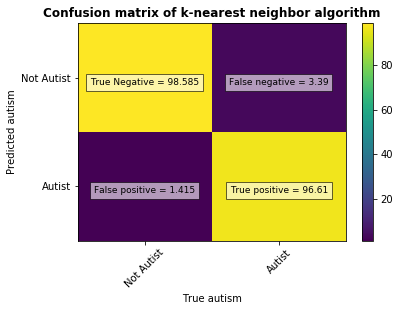

In [80]:
# Confusion matrix
false_negative=np.sum((np.array(y_test) == 1) & (y_pred == 0))/np.sum(np.array(y_test) == 1)
true_negative=np.sum((np.array(y_test) == 0) & (y_pred == 0))/np.sum(np.array(y_test) == 0)
true_positive=np.sum((np.array(y_test) == 1) & (y_pred == 1))/np.sum(np.array(y_test) == 1)
false_positive=np.sum((np.array(y_test) == 0) & (y_pred == 1))/np.sum(np.array(y_test) == 0)

# I create a matrix in percentage, with only three decimals, to be more readable
percent_matrix=np.round(np.array([[true_negative, false_negative], [false_positive, true_positive]])*100, 3)

# I plot the values and what they correspond to upon the plot
s = [['True Negative','False positive'], ['False negative', 'True positive']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[j][i])+" = "+ str(percent_matrix[i][j]), ha='center',va='top', bbox=dict(facecolor='white', alpha=0.6), fontsize=9)
    
# I set the labels of the axis and the title of the plot
plt.ylabel('Predicted autism')
plt.xlabel('True autism')
plt.title('Confusion matrix of k-nearest neighbor algorithm', fontdict = {'weight' : 'bold','size': 12})

# I set the x-ticks and y-ticks
classNames = ['Not Autist','Autist']
plt.xticks(np.arange(2), classNames, rotation=45)
plt.yticks(np.arange(2), classNames)

# I show the matrix
plt.imshow(percent_matrix, aspect='auto')  
plt.colorbar()


Here, I still have more false negatives than false positives. It may be due to one bias of my dataset: I have less autists than people that are not on the spectrum. Therefore, the model, because it is related to the neighbors, much more numerous when it comes to non autist people. 